<a href="https://colab.research.google.com/github/hans-elliott99/encoder-decoder-fromscratch/blob/main/examples/Seq2Seq_EN2FRTranslation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Text preprocessing
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import unicodedata
import string
from typing import Union
import numpy as np
import re


# Model/Train Helpers
import random
import time
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.lines import Line2D

# PyTorch
import torch

In [2]:
print(torch.cuda.is_available())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

True
cuda:0


In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Helpers

In [34]:
def plot_grad_flow_basic(raw_parameters : list, param_names : list=None, y_ax_max="max_average"):
    '''
    Plots the gradients flowing through different layers in the net during training.
    Can be used for checking for possible gradient vanishing / exploding problems.
    
    Usage: Provide the list of raw model parameters. Optionally provide list of names matching param order.
    y_ax_max is the y axis limit and is either "max_average" or "mean_average"
    Adapted from source: https://discuss.pytorch.org/t/check-gradient-flow-in-network/15063/10
    '''
    ave_grads = []
    max_grads= []
    layers = []
    for n, p in enumerate(raw_parameters):
        if(p.requires_grad) & (p.grad is not None): #and ("bias" not in n):
            layers.append(str(n))
            ave_grads.append(p.grad.abs().mean().item())
            max_grads.append(p.grad.abs().max().item())

    xticks = range(0,len(ave_grads), 1)
    y_min = min(ave_grads)
    y_max = max(ave_grads)
    if y_ax_max == "mean_average":
        y_max = (sum(ave_grads)/len(ave_grads))
    if param_names is not None:
        for x_ix in xticks:
            plt.text(x_ix, y_max/3, s=param_names[x_ix], rotation=90)

    plt.bar(range(len(max_grads)), max_grads, alpha=0.1, lw=1, color="c")
    plt.bar(range(len(max_grads)), ave_grads, alpha=0.1, lw=1, color="b")
    plt.hlines(0, 0, len(ave_grads)+1, lw=2, color="k" )
    plt.xticks(xticks, layers, rotation="vertical")
    plt.xlim(left=0, right=len(ave_grads))
    plt.ylim(bottom = y_min, top=y_max) # zoom in on the lower gradient regions
    plt.xlabel("Layers")
    plt.ylabel("average gradient")
    plt.title("Gradient flow")
    plt.grid(True)
    plt.legend([Line2D([0], [0], color="c", lw=4),
                Line2D([0], [0], color="b", lw=4),
                Line2D([0], [0], color="k", lw=4)], ['max-gradient', 'mean-gradient', 'zero-gradient'])

In [88]:
def words_to_ch_data(eng, fra, stoi, stop_char:str, device):
    """
    Converts words to character-level data.
    """
    assert len(eng)==len(fra)
    # Data
    ## block_size = context length: how many chars do we use to predict the next?
    X, Y = [], []
    for en, fr in zip(eng, fra):
        
        # diff = len(fr) - len(en)
        # if diff > 0:
        #     add_to_en = abs(diff)
        #     add_to_fr = 0
        # elif diff < 0:
        #     add_to_en = 0
        #     add_to_fr = abs(diff)
        # else:
        #     add_to_en = 0
        #     add_to_fr = 0

        english_ix, french_ix = [], []
        for ch in en:
            english_ix.append(stoi[ch])
        english_ix.append(stoi[stop_char])
        # english_ix += [stoi[stop_char]] * add_to_en

        for ch in fr:
            french_ix.append(stoi[ch])
        french_ix.append(stoi[stop_char])
        # french_ix += [stoi[stop_char]] * add_to_fr

        X.append(torch.tensor(english_ix, device=device))
        Y.append(torch.tensor(french_ix, device=device))

    return X, Y


def words_to_word_data(eng, fra, stoi, stop_char:str, device, keep_punct=""):
    """
    Converts words to word-level data.
    """
    assert len(eng)==len(fra)
    remove_punct = ''.join([p for p in string.punctuation if p not in keep_punct]) ##remove all punct except...
    # Data
    X, Y = [], []
    for en, fr in zip(eng, fra):
        # remove unwanted punctuation
        en = ''.join([c for c in en if c not in remove_punct]).lower()
        fr = ''.join([c for c in fr if c not in remove_punct]).lower()

        # split phrases into words
        english_ix, french_ix = [], []
        for wd in en.split():
            english_ix.append(stoi[wd])
        english_ix.append(stoi[stop_char])

        for wd in fr.split():
            french_ix.append(stoi[wd])
        french_ix.append(stoi[stop_char])

        X.append(torch.tensor(english_ix, device=device))
        Y.append(torch.tensor(french_ix, device=device))

    return X, Y



def split_samples(inputs, labels, frac=0.8, seed=123):
    "Split x and y tensors (inputs and labels) into train and test sets"
    
    assert len(inputs)==len(labels), f"len(inputs) {len(inputs)} does not match len(labels) {len(labels)}"
    # generate a list of indices to exclude. Turn in into a set for O(1) lookup time
    random.seed(seed)
    indx = list(set(random.sample(list(range(len(inputs))), int(frac*len(inputs)))))

    x_mask = torch.zeros((len(inputs)), dtype=torch.bool) #False
    x_mask[indx] = True

    y_mask = torch.zeros((len(inputs)), dtype=torch.bool) #False
    y_mask[indx] = True

    train_x = inputs[x_mask]
    train_y = labels[y_mask]

    test_x = inputs[~x_mask]
    test_y = labels[~y_mask]

    return train_x, train_y, test_x, test_y

In [6]:
def import_data(file_path, max_english_chars, max_french_chars):
    english, french = [],[]

    matches = ["(", "‽", "…", "€"]
    with open(file_path, encoding="utf-8") as file:
        for line in file:
            line = line.rstrip()
            line = line.replace(u"\u202f", " ")
            line = line.replace(u"\u3000", " ")
            line = line.replace(u"\u2000", " ")
            line = line.replace(u"\u200b", " ")
            line = line.replace(u"\xa0", " ")
            line = line.replace(u"\xad", " ")
            line = line.replace(u"\u2009", " ")
            line = line.replace("ú", "u")
            line = line.replace("–", "-")
            line = line.replace("а", "a")
            line = line.replace("‐", "-")
            line = line.replace("₂", "2")
            line = line.replace("\'", "'")
            if any(s in line for s in matches): ##removes some edge cases
                pass
            else:        
                eng, fra = line.split('\t')
            
            if (len(fra)>max_french_chars) | (len(eng)>max_english_chars):
                pass
            else:
                english.append(eng)
                french.append(fra)
    return english, french

# Model
## Encoder-Decoder Network with GRUs processing the sequences

In [117]:
class TranslGRU:
    def __init__(self, vocab_size, 
                       enc_embed_dim, dec_embed_dim,
                       dec_type, hidden_size, max_length,
                       stoi_mapping, start_chr, stop_chr
                ) -> None:
        """
        Define an Encoder-Decoder network each consisting of a GRU for sequence to sequence translation.
        n_letters = number of unique letters/characters that appear in the data.
        embed_dim = dimension of the embedding layer
        dec_type = "simple" or "attention"  
        hidden_size = desired number of elements in the hidden and cell states
        output_size = Dense layer ontop of the decoder converts last hidden state to logits of shape (output_size, 1)
        """
        # Model architecture
        self.input_size = vocab_size
        
        self.enc_embed_dim = enc_embed_dim
        self.dec_embed_dim = dec_embed_dim
        self.dec_type = dec_type
        self.max_length = max_length

        self.enc_hidden_size = hidden_size ## technically the dec hidden size has to be the same as the encoder rn
        self.dec_hidden_size = hidden_size ##

        self.output_size = vocab_size
        
        # Data processing
        self.stoi = stoi_mapping
        self.itos = {i:s for s, i in stoi_mapping.items()}

        assert start_chr in stoi_mapping
        assert stop_chr in stoi_mapping
        self.start_chr_ix = stoi_mapping[start_chr]
        self.stop_chr_ix = stoi_mapping[stop_chr]

    def init_hidden(self) -> torch.tensor:
        """Initialize hidden state. Returns: hidden"""
        hidden = torch.zeros((self.enc_hidden_size, 1), device=self.device)  #(hidden size , batch size)
        return hidden

    def init_weights(self, device, seed=123) -> None:
        """Initialize weight tensors for the model."""
        g = torch.Generator(device=device).manual_seed(seed)

        self.device = device
        self.params = []
        self.param_names = []

        self._init_enc_weights(g=g, device=device)
        self._init_dec_weights(g=g, device=device)
        
        for p in self.params:
            p.requires_grad = True

        self.n_parameters = self._count_params()

    def _init_enc_weights(self, g, device) -> None:
        """Initialize weight tensors for the decoder model."""
        std = 1.0 / np.sqrt(self.enc_hidden_size)
        concat_size = self.enc_embed_dim + self.enc_hidden_size

        self.enc_embed = (-std - std) * torch.rand((self.input_size, self.enc_embed_dim), generator=g, device=device) + std

        self.enc_W_reset = (-std - std) * torch.rand((self.enc_hidden_size, concat_size), generator=g, device=device) + std
        self.enc_br = torch.zeros((self.enc_hidden_size, 1), device=device)
        self.enc_W_update = (-std - std) * torch.rand((self.enc_hidden_size, concat_size), generator=g, device=device) + std
        self.enc_bu = torch.zeros((self.enc_hidden_size, 1), device=device)
        self.enc_W_htilde = (-std - std) * torch.rand((self.enc_hidden_size, concat_size), generator=g, device=device) + std
        #self.bh = torch.zeros((self.hidden_size, 1), device=device)
        
        self.params += [self.enc_embed, self.enc_W_reset, self.enc_br, self.enc_W_update, self.enc_bu, self.enc_W_htilde]
        self.param_names += ['enc_embed', 'enc_W_reset', 'enc_br', 'enc_W_update', 'enc_bu', 'enc_W_htilde']
        
    def _init_dec_weights(self, g, device) -> None:
        """Initialize weight tensors for the decoder."""
        std = 1.0 / np.sqrt(self.dec_hidden_size)
        concat_size = self.dec_embed_dim + self.dec_hidden_size

        if self.dec_type == "attention":
            self.W_att = (-std - std) * torch.rand((self.max_length, concat_size), generator=g, device=device) + std
            self.ba = torch.zeros((self.max_length, 1), device=device)
            self.W_rel = (-std - std) * torch.rand((self.dec_embed_dim, concat_size), generator=g, device=device) + std
            self.brel = torch.zeros((self.dec_embed_dim, 1), device=device)

            self.params += [self.W_att, self.ba, self.W_rel, self.brel]
            self.param_names += ['W_att', 'ba', 'W_rel', 'brel']

        self.dec_embed = (-std - std) * torch.rand((self.input_size, self.dec_embed_dim), generator=g, device=device) + std
        self.dec_W_reset = (-std - std) * torch.rand((self.dec_hidden_size, concat_size), generator=g, device=device) + std
        self.dec_br = torch.zeros((self.dec_hidden_size, 1), device=device)
        self.dec_W_update = (-std - std) * torch.rand((self.dec_hidden_size, concat_size), generator=g, device=device) + std
        self.dec_bu = torch.zeros((self.dec_hidden_size, 1), device=device)
        self.dec_W_htilde = (-std - std) * torch.rand((self.dec_hidden_size, concat_size), generator=g, device=device) + std
        #self.bh = torch.zeros((self.hidden_size, 1), device=device)
        # FC HEAD
        self.W_h2o = (-std - std) * torch.rand((self.output_size, self.dec_hidden_size), generator=g, device=device) + std
        self.b_h20 = torch.zeros((self.output_size, 1), device=device)

        self.params += [self.dec_embed, self.dec_W_reset, self.dec_br, self.dec_W_update, self.dec_bu, self.dec_W_htilde, self.W_h2o, self.b_h20]
        self.param_names += ['dec_embed', 'dec_W_reset', 'dec_br', 'dec_W_update', 'dec_bu', 'dec_W_htilde', 'W_h2o', 'b_h20']


    def encoder(self, hidden_prev, x_tensor_t):
        "ENCODER AT STEP T"
        input = self.enc_embed[x_tensor_t].unsqueeze(dim=1)
        hidden_new = self.gru(input, hidden_prev, self.enc_W_reset, self.enc_br, self.enc_W_update, self.enc_bu, self.enc_W_htilde)
        return hidden_new
    
    def simple_decoder(self, context_vector, input_char_t):
        "DECODER AT STEP T"
        input = self.dec_embed[input_char_t].unsqueeze(dim=1)
        hidden_new = self.gru(input, context_vector, self.dec_W_reset, self.dec_br, self.dec_W_update, self.dec_bu, self.dec_W_htilde)
        
        # run hidden state through linear layer to predict next char
        # output = torch.softmax(self.linear(hidden_new))
        logits = self.linear_head(hidden_new)
        next_input_char = int(torch.argmax(logits, dim=0).item()) ##return just the index

        return hidden_new, logits, next_input_char
    
    def attention_decoder(self, enc_outputs, prev_hidden, input_char_t):
        "ATTENTION DECODER AT STEP T"
        # embed the current character and concatenate with previous hidden state
        embedded = self.dec_embed[input_char_t].unsqueeze(dim=1) ##shape embed_dim, 1
        concat1 = torch.cat((embedded, prev_hidden), dim=0).to(self.device)      ##shape embed_dim+hidden_size, 1
        # calculate attention weights by passing in the concatenation & softmaxing
        # apply the attention vector to the context vector
        atten = torch.nn.functional.softmax(self.linear_attention(concat1), dim=0).T ##shape 1, max_len. & enc_outputs have shape max_len, hidden_size
        atten_weighted = (atten @ enc_outputs).squeeze(dim=0)            ##shape hidden_size
        ## attention vector is broadcast over the entire enc output matrix (where each row is a hidden state), weighting

        # concat the attention-weighted context with the input embedding and pass through a ReLU linear layer
        concat2 = torch.cat((embedded, atten_weighted.unsqueeze(dim=1)), dim=0).to(self.device)          ##shape embed_dim+hidden_size, 1
        gru_input = torch.nn.functional.relu(self.linear_relu(concat2))                 ##shape embed_dim, 1

        # pass the attention-processed inputs into the decoder gru along with previous hidden state to generate new hidden
        hidden_new = self.gru(gru_input, prev_hidden, self.dec_W_reset, self.dec_br, self.dec_W_update, self.dec_bu, self.dec_W_htilde)

        # run hidden state through linear layer to predict next char
        logits = self.linear_head(hidden_new)  
        next_input_char = int(torch.argmax(logits, dim=0).item())
        
        return hidden_new, logits, next_input_char
    
    def gru(self, input, hidden,
                  W_reset, br,
                  W_update, bu,
                  W_htilde
                  ) -> torch.tensor:
        """One forward step in a GRU cell to update hidden state. Returns: hidden_new"""
        # Concatenate inputs with incoming hidden state
        concat_raw = torch.cat((input, hidden), dim=0)

        # Calc reset gate and apply to hidden state to produce gated/reset hidden state
        r_gate = torch.sigmoid(W_reset @ concat_raw + br)
        hidden_reset = hidden * r_gate

        # Concatenate inputs with gated hidden state
        concat_gated = torch.cat((input, hidden_reset), dim=0)
        # Calculate h tilde, the proposed new hidden state, using the gated concatenation
        h_tilde = torch.tanh(W_htilde @ concat_gated)

        # Calc update gate using the raw/ungated concatenation
        u_gate = torch.sigmoid(W_update @ concat_raw + bu)

        # Update hidden state with (1 - update gate) * hidden_t-1 + (update gate * h tilde):
        hidden_new = (1 - u_gate) * hidden + u_gate * h_tilde
        
        return hidden_new
    
    def linear_head(self, input):
        return self.W_h2o @ input + self.b_h20

    def linear_attention(self, input):
        return self.W_att @ input + self.ba

    def linear_relu(self, input):
        return self.W_rel @ input + self.brel

    def backprop_update(self, optimizer) -> None:
        """Zero gradients, backpropogate via loss, and update params with optimizer"""
        # ensure gradients are zerod
        # for p in self.params:
        #     p.grad = None
        optimizer.zero_grad(set_to_none=True)
        # backprop
        self.loss.backward()

        # update
        # for i, p in enumerate(self.params):
        #     p.data += -lr * p.grad
        optimizer.step()

    def _count_params(self):
        n_params = 0
        for p in self.params:
            n_params += p.nelement()
        return n_params


    def forward(self, x:torch.tensor, y:torch.tensor=None, teacher_forcing_ratio=0.0, max_length=100):
        """
        Perform an entire forward pass of one sample to calculate outputs and calculate loss if y is provided.
        Returns output_chars, loss.
        """

        # Determine maximum length to predict for
        if y is None:
            target_length = max_length
        else:
            target_length = y.shape[0]
            # y_ohe = torch.nn.functional.one_hot(y, num_classes=self.output_size)


        # ENCODER
        # Tensor to store the encoder gru's outputs at each timestep (as columns)
        enc_outputs = torch.zeros((self.max_length, self.enc_hidden_size), device=self.device)
        # Initialize hidden state with zeros
        enc_hidden = self.init_hidden()

        # Pass through X sequentially into the encoder and update hidden state
        loss = 0
        for t in range(x.shape[0]):
            enc_hidden = self.encoder(hidden_prev=enc_hidden, x_tensor_t=x[t])
            enc_outputs[t] = enc_hidden.squeeze(1)
        
        # encoder passes the finall hidden state (context vector) to simple decoder or attention decoder
        # the attention decoder also uses the enc_outputs matrix (ie, it uses all of the hidden states produced in the loop above)

        # DECODER
        use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False ##returns True if the float between [0, 1] is less than ratio
        output_chrs = []
        dec_hidden = enc_hidden ##last enc hidden state is the first context vector for simple decoder/first hidden state for attention decoder

        # Use the final hidden state (context vector) and the start token to start the decoding and predict the next character in the sequence
        # Repeat until the stop token is predicted or the target length is reached
        input_chr = self.start_chr_ix 
        for t in range(target_length):
            # SIMPLE
            if self.dec_type=="simple":
                # The last encoder hidden vector is 
                dec_hidden, logits, input_chr = self.simple_decoder(context_vector=dec_hidden, input_char_t=input_chr)
                output_chrs.append(input_chr)
            
            # ATTENTION
            if self.dec_type=="attention":
                dec_hidden, logits, input_chr = self.attention_decoder(enc_outputs=enc_outputs, 
                                                                       prev_hidden=dec_hidden,
                                                                       input_char_t=input_chr)  ##returns predicted character
                output_chrs.append(input_chr)

            if y is not None:
                loss += torch.nn.functional.cross_entropy(logits.squeeze(), y[t])

            if input_chr == self.stop_chr_ix:
                break

            if use_teacher_forcing:
                # overwrite the predicted input_chr since we will give the model the true input chr
                input_chr = y[t].item()
        
        # Save final loss for backpropagation through time
        self.loss = loss

        return output_chrs, loss
    
    def evaluate(self, english_text:str="hello", level="word"):
        """Forward passes english_txt + 'stop_chr' through the model. level is either 'word' or 'character'."""
        remove_punct = ''.join([p for p in string.punctuation if p not in "'<"])

        if level=="word":
            text = english_text+" <"
            text = ''.join([c for c in text.lower() if c not in remove_punct])
            input = torch.tensor([self.stoi[w] for w in text.split()], device=self.device)
        elif level=="character":
            text = english_text+"<"
            input = torch.tensor([self.stoi[c] for c in text], device=self.device)

        with torch.no_grad():
            for t in range(input.shape[0]):
                output, loss = self.forward(input, y=None)

        spaces=True
        if level=='character': spaces=False
        pred_transl, _ = self.decode_output(output,spaces=spaces)

        # if check_google:
        #     try:
        #         translator = google_translator()
        #         google_transl = translator.translate(english_text, lang_src='en', lang_tgt='fr')
        #     except:
        #         google_transl = "Error accessing Google translate."
        #     return pred_transl, google_transl
        # else:

        return pred_transl

    def decode_output(self, output, label=None, spaces=False):
        """Returns predicted translation, true translation ( = None if label is None)"""
        pred = []
        truth = [] if label is not None else None
        
        # input = [itos[ix.item()] for ix in x]
        for i in range(len(output)):
            pred.append(self.itos[output[i]])
        if label is not None:
            for i in range(len(label)):
                truth.append(self.itos[label[i].item()])

        if spaces:
            pred_transl = " ".join(pred)
            true_transl = " ".join(truth) if label is not None else None
        else:
            pred_transl = "".join(pred)
            true_transl = "".join(truth) if label is not None else None
        return pred_transl, true_transl


# Data

In [8]:
MAX_CHARS = 30
START_CHR = '>'
STOP_CHR = '<'

english, french = import_data("/content/gdrive/MyDrive/Colab/seq2seq_transl/eng-fra.txt",
                              max_english_chars=MAX_CHARS, max_french_chars=MAX_CHARS)

Model can operate on the character level...

In [9]:
# eng_chars = set(''.join(english))
# fra_chars = set(''.join(french))
all_chars = set(''.join(english + french))

stoi = {s:i+2 for i, s in enumerate(all_chars)} ##create dictionary mapping from char to int
stoi[START_CHR] = 1
stoi[STOP_CHR] = 0
itos = {i:s for s, i in stoi.items()}


print(len(english))
print(len(all_chars))
print("max english length = ", len(max(english, key=len)), "chars")
print("max french length = ", len(max(french, key=len)), "chars")

51177
98
max english length =  30 chars
max french length =  30 chars


Or the word level.

In [89]:
KEEP_PUNCT = "'-"
remove_punct = ''.join([p for p in string.punctuation if p not in KEEP_PUNCT])
# join all phrases with space in between
all_words = ' '.join(english + french)
# remove punctuation characters except for those not in remove_punct
all_words = ''.join([c for c in all_words if c not in remove_punct])

# create mapping from string to int
wtoi = {word:i+2 for i, word in enumerate( sorted(set(all_words.lower().split())) )}
wtoi[START_CHR] = 1
wtoi[STOP_CHR] = 0

itow = {i:w for w, i in wtoi.items()}

In [90]:
print("total words in vocab =", len(wtoi))

total words in vocab = 19222


Now generate inputs from the text data and the text to int mappings.

In [91]:
N_SAMPLES = 1000 #len(english)
Xs, Ys = words_to_word_data(english[:N_SAMPLES], french[:N_SAMPLES], 
                          wtoi, stop_char=STOP_CHR, 
                          device=device,
                          keep_punct=KEEP_PUNCT)

# Train

And initialize an encoder-decoder model.

In [118]:
# MODEL
n_words = len(wtoi)
hidden_size = 128
emb_dim = 64

model = TranslGRU(vocab_size=n_words,
                  enc_embed_dim=emb_dim,
                  dec_embed_dim=emb_dim,
                  dec_type="attention",
                  hidden_size=hidden_size,
                  max_length=MAX_CHARS,
                  stoi_mapping=wtoi, 
                  start_chr=START_CHR, stop_chr=STOP_CHR
                  )
model.init_weights(device=device)

print("MODEL PARAMETERS:", model.n_parameters)
print("training samples:", len(Xs))

MODEL PARAMETERS: 5106164
training samples: 1000


In [102]:
for n, p in zip(model.param_names, model.params):
    print(f"| {n}  | {p.shape[0], p.shape[1]} | n =  {p.nelement():,} | {p.device}")

| enc_embed  | (19222, 64) | n =  1,230,208 | cuda:0
| enc_W_reset  | (128, 192) | n =  24,576 | cuda:0
| enc_br  | (128, 1) | n =  128 | cuda:0
| enc_W_update  | (128, 192) | n =  24,576 | cuda:0
| enc_bu  | (128, 1) | n =  128 | cuda:0
| enc_W_htilde  | (128, 192) | n =  24,576 | cuda:0
| W_att  | (30, 192) | n =  5,760 | cuda:0
| ba  | (30, 1) | n =  30 | cuda:0
| W_rel  | (64, 192) | n =  12,288 | cuda:0
| brel  | (64, 1) | n =  64 | cuda:0
| dec_embed  | (19222, 64) | n =  1,230,208 | cuda:0
| dec_W_reset  | (128, 192) | n =  24,576 | cuda:0
| dec_br  | (128, 1) | n =  128 | cuda:0
| dec_W_update  | (128, 192) | n =  24,576 | cuda:0
| dec_bu  | (128, 1) | n =  128 | cuda:0
| dec_W_htilde  | (128, 192) | n =  24,576 | cuda:0
| W_h2o  | (19222, 128) | n =  2,460,416 | cuda:0
| b_h20  | (19222, 1) | n =  19,222 | cuda:0


Let's try training the model on one example.

In [114]:
# Testing model on a single phrase
optimizer = torch.optim.Adam(model.params, lr=0.01)
# (takes more iterations for longer phrases to be learned)
for _ in range(200):
    s = 999

    x, y = Xs[s], Ys[s]

    output, loss = model.forward(x, y, teacher_forcing_ratio=0)
    model.backprop_update(optimizer)

print(loss.item() / len(y))
guess, true = model.decode_output(output, label=y, spaces=True)
print("Guess:", guess)
print("True:", true)
print("English:", ' '.join([itow[i.item()] for i in x]))

0.013236501812934875
Guess: j'ai reçu de l'aide <
True: j'ai reçu de l'aide <
English: i had help <


Now for some more serious training...

In [127]:
# Reset weights
model.init_weights(device, seed=10418)
optimizer = torch.optim.Adam(model.params, lr=3e-4)

TF_RATIO = 0.5
print_every = 1
plot_every = 1
epochs = 20
log_file = '/content/gdrive/MyDrive/Colab/seq2seq_transl/train-log.txt'

loss_list = []
open(log_file, 'w').close() #empty the log file

In [130]:
assert (Xs[0].device == device) & (Ys[0].device == device), f"put data on {device}"

strt = time.time()
for epoch in range(1, epochs+1):
    ep_loss = 0
    sample_ix = [i for i in range(0, N_SAMPLES)]
    random.shuffle(sample_ix)

    # iterate through every sample in the training data
    for sample in sample_ix:
        x, y = Xs[sample], Ys[sample] ##already on device
        output, loss = model.forward(x, y, teacher_forcing_ratio=TF_RATIO)
        ep_loss += loss.item()

        model.backprop_update(optimizer)
    
    # write epoch loss to log
    with open(log_file, 'a') as f:
      f.write(f'epoch {epoch}; loss {ep_loss / N_SAMPLES} \n')

    # print
    if epoch % print_every == 0:
        stp = time.time()
        guess, true = model.decode_output(output, label=y, spaces=True) ##use the last training sample as an example

        print(f"({epoch}/{epochs}) loss = {round(ep_loss/N_SAMPLES, 6)}", end=" ")
        print(f"(elapsed: {round(stp-strt, 3)}s)")
        print("GUESS:", guess, end="   ")
        print("TRUTH:", true, end="   ")
        print("ENG:", ' '.join([itow[i.item()] for i in x]))

    if epoch % plot_every == 0:
        loss_list.append(ep_loss/N_SAMPLES)

(1/20) loss = 6.895785 (elapsed: 8.911s)
GUESS: nous avons <   TRUTH: nous discutâmes <   ENG: we talked <
(2/20) loss = 6.701077 (elapsed: 17.812s)
GUESS: je suis prêt <   TRUTH: je suis dur à cuire <   ENG: i'm tough <
(3/20) loss = 6.580071 (elapsed: 26.738s)
GUESS: soyez fait <   TRUTH: soyez satisfaites <   ENG: be content <
(4/20) loss = 6.486535 (elapsed: 35.659s)
GUESS: assieds-toi <   TRUTH: calmez-vous <   ENG: cool down <
(5/20) loss = 6.306553 (elapsed: 44.539s)
GUESS: à <   TRUTH: est-ce sérieux <   ENG: seriously <
(6/20) loss = 6.122873 (elapsed: 53.36s)
GUESS: qui est <   TRUTH: qui est-ce <   ENG: who is it <
(7/20) loss = 5.930785 (elapsed: 62.29s)
GUESS: je me suis pas <   TRUTH: je me fais vraiment du souci <   ENG: i do worry <
(8/20) loss = 5.879765 (elapsed: 71.252s)
GUESS: je ferai <   TRUTH: je passerai <   ENG: i'll pass <
(9/20) loss = 5.588598 (elapsed: 80.214s)
GUESS: il est <   TRUTH: il a laissé tomber <   ENG: he quit <
(10/20) loss = 5.563114 (elapsed: 

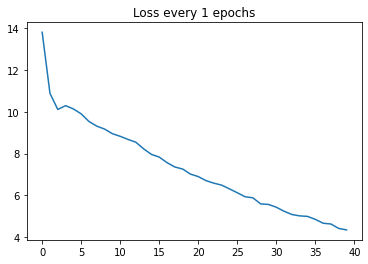

In [131]:
losses = []
with open(log_file, "r") as f:
  for line in f:
    line = line.strip()
    losses.append( float(line.split()[-1]) )

plt.plot(losses)
plt.title(f"Loss every {plot_every} epochs")
plt.show()

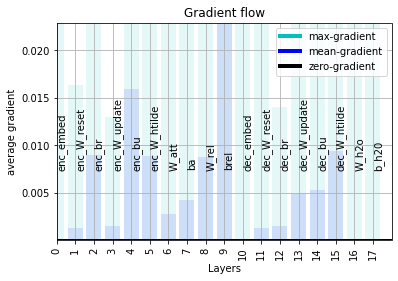

In [132]:
plot_grad_flow_basic(model.params, model.param_names, y_ax_max="max_average")

# Inference

In [136]:
model.evaluate("Deep learning is fun", level="word") ##my output is 'trouve un boulot <' which actually translates to 'find a job'... damn

'trouve un boulot <'